# Directed search (optimization) using the workbench

## 01. Introduction and model specification

In the previous assignments, we have been using sampling to investigate the uncertainty space and the lever space. However, we can also use optimization algorithms to search through these spaces. Most often, you would use optimization to search through the lever space in order to find promising policies. However, we can also use optimization to search through the uncertainty space in order to find for example a worst case scenario. In this assignment, we are going through the basics of using the optimization functionality of the workbench. 

For optimization, the ema_workbench relies on a library called platypus-opt. *platypus-opt* is python package developed by David Hadka (http://platypus.readthedocs.io/en/latest/) for multi-objective optimization. It allows an explicit specification of the problem components (levers, objectives, constraints). The package includes several multi-objective evolutionary algorithms, therefore the users can choose the algorithm they wish to use. 

you can use pip to install it:

```
pip install platypus-opt
```

Start with importing the lake model we have used in previous weeks and connecting it to the workbench. However, we need to make one change: for each outcome of interest we need to specify whether we want to maximize or minimize it, we can use the `kind` kwarg for this. `max_P` should be minimized, while all other outcomes are to be maximized. As a further simplification for this tutorial, we are ignoring the inertia objective. We do this by not setting the `kind` kwarg. 


In [1]:
import numpy as np
import pandas as pd

from lakemodel_function import lake_problem

from ema_workbench import (Model, RealParameter, ScalarOutcome,
                           MultiprocessingEvaluator, ema_logging,
                           Constant)

ema_logging.log_to_stderr(ema_logging.INFO)

#instantiate the model
lake_model = Model('lakeproblem', function=lake_problem)
lake_model.time_horizon = 100 # used to specify the number of timesteps

#specify uncertainties
lake_model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('delta', 0.93, 0.99)]

# set levers, one for each time step
lake_model.levers = [RealParameter(str(i), 0, 0.1) for i in 
                     range(lake_model.time_horizon)] # we use time_horizon here

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE),
                       ScalarOutcome('inertia'),
                       ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE)]

## 02. Performing the optimization

Instead of using `perform_experiments`, we will be using `optimize`. There is several kwargs that we need to provide, so let's go through all:

* **algorithm**; We can specify which algorithm we want to use. The default is $\epsilon$-NSGA2, a state of the art many-objective evolutionary algorithm. We can use any of the other algorithms that come with platypus-opt, or the GenerationalBorg algorithm that comes with the workbench. For now, we won't change this.
* **nfe**; the number of function evaluations, this is to be determined by analyzing whether the algorithm has converged
* **searchover**; are we optimizing over the uncertainties or the levers? Most often we will be searching over the levers, so we don't generally need to change this. 
* **reference**; If we are searching over levers, what values should we assume for the uncertainties? Reference allows us to specify this. If searchover is set to levers, reference should be a `Scenario` or None, while if searchover is uncertainties, reference should be a `Policy` or None. In case of a None, the default values of the underlying model are unchanged
* **constraints**; see below
* **epsilons**; many state of the art MOEA's rely on a epsilon dominance. Basically, a grid is imposed on the objective space, and per grid cell a single solution is maintained. The granularity of the grid is specified through the epsilon values. Epsilon should be a list or array with a length equal to the number of outcomes. Below, we will see what the impact is of changing epsilon values.
* **convergence**; In order to track whether a MOEA has converged to the optimum solutions, we use convergence metrics. The workbench offers epsilon progress and hypervolume as two often used metrics for this. We will explore these below. 

let's start with a simple optimization using 5000 nfe, and the 0.25, 0.1, and 0.1 as epsilon values. 

In [2]:
with MultiprocessingEvaluator(lake_model) as evaluator:
    results = evaluator.optimize(nfe=5000, epsilons=[0.25, 0.1, 0.1])

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/5000 nfe
[MainProcess/INFO] generation 5: 500/5000 nfe
[MainProcess/INFO] generation 10: 1000/5000 nfe
[MainProcess/INFO] generation 15: 1500/5000 nfe
[MainProcess/INFO] generation 20: 2000/5000 nfe
[MainProcess/INFO] generation 25: 2500/5000 nfe
[MainProcess/INFO] generation 30: 3000/5000 nfe
[MainProcess/INFO] generation 35: 3500/5000 nfe
[MainProcess/INFO] generation 40: 4000/5000 nfe
[MainProcess/INFO] generation 45: 4500/5000 nfe
[MainProcess/INFO] optimization completed, found 8 solutions
[MainProcess/INFO] terminating pool


In [3]:
results

,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,max_P,utility,reliability
0,0.037657,0.066864,0.098438,0.035290,0.074083,0.023045,0.006580,0.030652,0.042656,0.000132,...,0.036235,0.095767,0.095421,0.061358,0.082605,0.084066,0.021547,2.213604,1.060480,0.2102
1,0.086031,0.063820,0.042314,0.012736,0.020972,0.023121,0.045238,0.010427,0.006044,0.011714,...,0.047485,0.091285,0.004012,0.072523,0.085645,0.071160,0.002221,2.166280,0.704217,0.4106
2,0.043955,0.063623,0.048904,0.012736,0.083512,0.022640,0.096243,0.002497,0.051862,0.003652,...,0.020504,0.087273,0.004019,0.079706,0.048658,0.050480,0.002311,2.130997,0.610055,0.5680
3,0.084234,0.072829,0.090469,0.008295,0.068197,0.024053,0.002765,0.009833,0.006569,0.012180,...,0.025761,0.095994,0.048926,0.005930,0.081458,0.075116,0.010166,2.177817,0.826090,0.3198
4,0.082716,0.057620,0.045992,0.012428,0.021045,0.022658,0.094423,0.002132,0.051697,0.003553,...,0.020503,0.078331,0.004019,0.004765,0.010115,0.074414,0.053042,0.341794,0.509395,1.0000
5,0.095486,0.093994,0.093294,0.095167,0.082222,0.099182,0.097186,0.077100,0.093426,0.096193,...,0.084484,0.096502,0.090066,0.099850,0.096396,0.094051,0.075975,2.262975,1.530455,0.0700
6,0.082440,0.063217,0.048904,0.012386,0.020095,0.000430,0.097950,0.002132,0.050201,0.003535,...,0.005446,0.050378,0.004019,0.062004,0.010115,0.049367,0.053052,0.224333,0.451929,1.0000
7,0.094343,0.090507,0.093371,0.031362,0.065315,0.079491,0.033690,0.001829,0.092820,0.096952,...,0.081654,0.082264,0.067184,0.096257,0.083952,0.047169,0.075883,2.248101,1.332335,0.1083


In [4]:
results.sort_values('max_P', ascending=False)

,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,max_P,utility,reliability
5,0.095486,0.093994,0.093294,0.095167,0.082222,0.099182,0.097186,0.077100,0.093426,0.096193,...,0.084484,0.096502,0.090066,0.099850,0.096396,0.094051,0.075975,2.262975,1.530455,0.0700
7,0.094343,0.090507,0.093371,0.031362,0.065315,0.079491,0.033690,0.001829,0.092820,0.096952,...,0.081654,0.082264,0.067184,0.096257,0.083952,0.047169,0.075883,2.248101,1.332335,0.1083
0,0.037657,0.066864,0.098438,0.035290,0.074083,0.023045,0.006580,0.030652,0.042656,0.000132,...,0.036235,0.095767,0.095421,0.061358,0.082605,0.084066,0.021547,2.213604,1.060480,0.2102
3,0.084234,0.072829,0.090469,0.008295,0.068197,0.024053,0.002765,0.009833,0.006569,0.012180,...,0.025761,0.095994,0.048926,0.005930,0.081458,0.075116,0.010166,2.177817,0.826090,0.3198
1,0.086031,0.063820,0.042314,0.012736,0.020972,0.023121,0.045238,0.010427,0.006044,0.011714,...,0.047485,0.091285,0.004012,0.072523,0.085645,0.071160,0.002221,2.166280,0.704217,0.4106
2,0.043955,0.063623,0.048904,0.012736,0.083512,0.022640,0.096243,0.002497,0.051862,0.003652,...,0.020504,0.087273,0.004019,0.079706,0.048658,0.050480,0.002311,2.130997,0.610055,0.5680
4,0.082716,0.057620,0.045992,0.012428,0.021045,0.022658,0.094423,0.002132,0.051697,0.003553,...,0.020503,0.078331,0.004019,0.004765,0.010115,0.074414,0.053042,0.341794,0.509395,1.0000
6,0.082440,0.063217,0.048904,0.012386,0.020095,0.000430,0.097950,0.002132,0.050201,0.003535,...,0.005446,0.050378,0.004019,0.062004,0.010115,0.049367,0.053052,0.224333,0.451929,1.0000


In [5]:
results.sort_values('utility', ascending=True)

,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,max_P,utility,reliability
6,0.082440,0.063217,0.048904,0.012386,0.020095,0.000430,0.097950,0.002132,0.050201,0.003535,...,0.005446,0.050378,0.004019,0.062004,0.010115,0.049367,0.053052,0.224333,0.451929,1.0000
4,0.082716,0.057620,0.045992,0.012428,0.021045,0.022658,0.094423,0.002132,0.051697,0.003553,...,0.020503,0.078331,0.004019,0.004765,0.010115,0.074414,0.053042,0.341794,0.509395,1.0000
2,0.043955,0.063623,0.048904,0.012736,0.083512,0.022640,0.096243,0.002497,0.051862,0.003652,...,0.020504,0.087273,0.004019,0.079706,0.048658,0.050480,0.002311,2.130997,0.610055,0.5680
1,0.086031,0.063820,0.042314,0.012736,0.020972,0.023121,0.045238,0.010427,0.006044,0.011714,...,0.047485,0.091285,0.004012,0.072523,0.085645,0.071160,0.002221,2.166280,0.704217,0.4106
3,0.084234,0.072829,0.090469,0.008295,0.068197,0.024053,0.002765,0.009833,0.006569,0.012180,...,0.025761,0.095994,0.048926,0.005930,0.081458,0.075116,0.010166,2.177817,0.826090,0.3198
0,0.037657,0.066864,0.098438,0.035290,0.074083,0.023045,0.006580,0.030652,0.042656,0.000132,...,0.036235,0.095767,0.095421,0.061358,0.082605,0.084066,0.021547,2.213604,1.060480,0.2102
7,0.094343,0.090507,0.093371,0.031362,0.065315,0.079491,0.033690,0.001829,0.092820,0.096952,...,0.081654,0.082264,0.067184,0.096257,0.083952,0.047169,0.075883,2.248101,1.332335,0.1083
5,0.095486,0.093994,0.093294,0.095167,0.082222,0.099182,0.097186,0.077100,0.093426,0.096193,...,0.084484,0.096502,0.090066,0.099850,0.096396,0.094051,0.075975,2.262975,1.530455,0.0700


Since we are dealing with 3 outcomes of interest, we can still visualize our results in a 3d scatter plot. Alternatively, we can visualize it using a so-called parallel coordinate plot. In a parallel coordinate plot, the dimensions are visualized side by side. A line connecting the dimensions is a single point in the multidimensional space. For more than 3 dimensions, parallel coordiante plots are prefered over 3d scatter plots with additional visual encodings for the other dimensions. The workbench has support for parallel coordinate plots using `ema_workbench.analysis.parcoords`

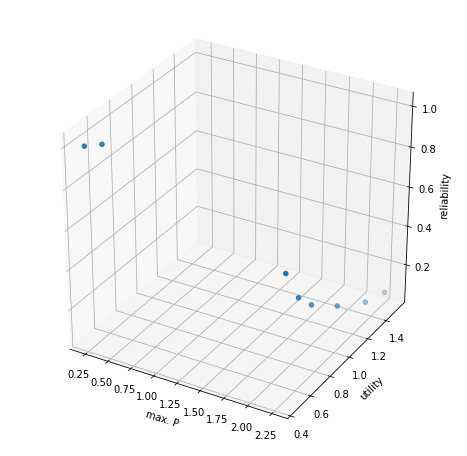

In [6]:
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.pyplot as plt
%matplotlib inline

outcomes = results.loc[:, ['max_P', 'utility', 'reliability']]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(outcomes.max_P, outcomes.utility, outcomes.reliability)
ax.set_xlabel('max. P')
ax.set_ylabel('utility')
ax.set_zlabel('reliability')
plt.show()

C:\Users\bjafino\anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\bjafino\anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\bjafino\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


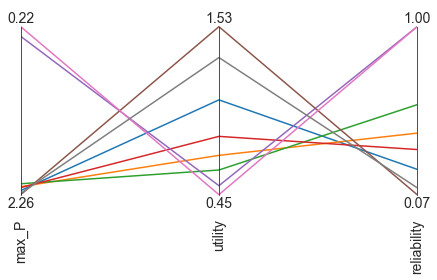

In [7]:
from ema_workbench.analysis import parcoords

limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)

# we invert this axis so direction of desirability is the same 
axes.invert_axis('max_P') 
plt.show()


As you can see, the parcoords figure is easier to interpret once you have learned how to read them. We can see a clear tradeoff between max_P and reliability on the one hand, and utility on the other. This is indicated by the crossing lines in between these respective dimensions. 

for the remainder of this tutorial, we will be using a four objective formulation of the problem. We add the intertia objective and we want to maximize it.

In [8]:
#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE),
                       ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE),
                       ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE)]

In [9]:
with MultiprocessingEvaluator(lake_model) as evaluator:
    results = evaluator.optimize(nfe=2000, epsilons=[0.25, 0.1, 0.1, 0.1])

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/2000 nfe
[MainProcess/INFO] generation 5: 500/2000 nfe
[MainProcess/INFO] generation 10: 1000/2000 nfe
[MainProcess/INFO] generation 15: 1500/2000 nfe
[MainProcess/INFO] optimization completed, found 17 solutions
[MainProcess/INFO] terminating pool


## 03. Re-evaluation under deep uncertainties

So far, we optimize the policy levers 'L' under just one scenario. To identify which optimized policy performs better under a larger number of scenarios, we re-evaluate the optimized policies under deep uncertainties.

For simplicity, we take only optimized policies which the reliability score is higher than 0.5.

In [10]:
logical = results.reliability > 0.5

#check the remaining number of policies with
np.sum(logical)

5

Let's see the performance of these policies under the baseline scenario 

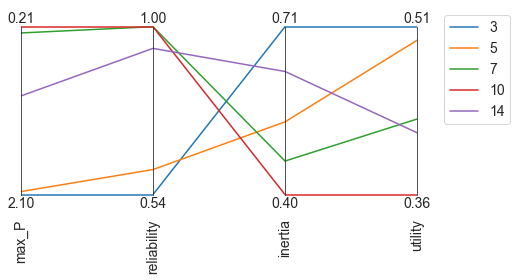

In [11]:
from ema_workbench.analysis import parcoords
import seaborn as sns
import matplotlib.pyplot as plt

colors = sns.color_palette()
outcomes = results[logical].loc[:, ['max_P', 'reliability', 'inertia', 'utility']]

limits = parcoords.get_limits(outcomes)
paraxes = parcoords.ParallelAxes(limits)
for i, (index, row) in enumerate(outcomes.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()

# we invert this axis so direction of desirability is the same 
paraxes.invert_axis('max_P') 
plt.show()

Now we create a dataframe which contains only the values of the levers/policies.

In [12]:
policies = results[logical]
policies = policies.drop([o.name for o in lake_model.outcomes], axis=1)
policies

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
3,0.004975,0.048541,0.068646,0.002952,0.004584,0.055323,0.007033,0.014208,0.027895,0.010655,...,0.040826,0.004615,0.006613,0.085979,0.014015,0.074454,0.046725,0.000578,0.055523,0.003534
5,0.039634,0.051991,0.009576,0.041603,0.004316,0.002830,0.052633,0.047225,0.005316,0.005785,...,0.031640,0.029544,0.025985,0.003079,0.078272,0.039385,0.004981,0.000134,0.032223,0.001067
7,0.008435,0.032373,0.079667,0.023555,0.041500,0.002803,0.009285,0.008516,0.029188,0.006743,...,0.018218,0.005803,0.020734,0.005597,0.001449,0.003099,0.061742,0.001029,0.005904,0.001442
10,0.008435,0.032373,0.074136,0.023555,0.005545,0.002803,0.009285,0.008516,0.029188,0.006743,...,0.018218,0.005803,0.020734,0.005597,0.001449,0.003099,0.061742,0.001081,0.005904,0.001442
14,0.004975,0.048541,0.016592,0.002952,0.004578,0.057531,0.007033,0.014208,0.004132,0.004232,...,0.039573,0.004615,0.037095,0.092991,0.011846,0.010658,0.046725,0.000135,0.055523,0.003534


We then transform the dataframe into a list of dictionary, so it can be passed to the EMA workbench's interface.

In [13]:
from ema_workbench import Policy

policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

We evaluate each policy under 1000 scenarios.

In [14]:
n_scenarios = 1000
with MultiprocessingEvaluator(lake_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 5 policies * 1 model(s) = 5000 experiments
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 4500 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [15]:
experiments, outcomes = results
outcomes_df = pd.DataFrame(outcomes)

outcomes_df['policy'] = experiments['policy']

Similar to the open exploration example, we can visualize the results of this reevaluation.

In [16]:
outcomes_df.columns

Index(['max_P', 'utility', 'inertia', 'reliability', 'policy'], dtype='object')

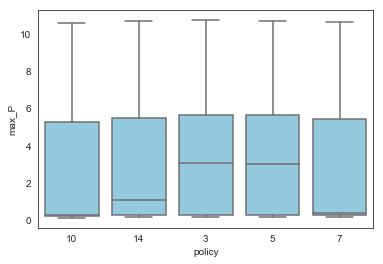

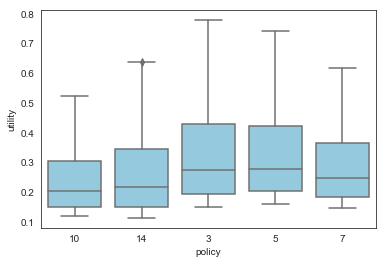

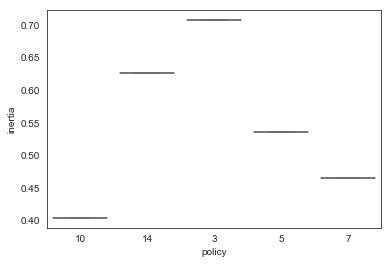

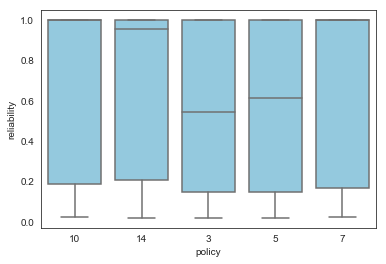

In [17]:
for var in outcomes_df.columns[:-1]:
    sns.boxplot(x='policy', y=var, data=outcomes_df, color='skyblue')
    plt.show()

## 04. Robustness analysis

Sometimes it is difficult to understand which policy performs better under deep uncertainties, by only looking at the boxplots of the results as above. We can use robustness metrics for comparing the performance of policies across a large number of scenarios. For further information about robustness metrics, you can look at https://doi.org/10.1002/2017EF000649

In this exercise, we will use the satisficing criterion as our robustness metric. Satisficing criterion counts the number of scenarios in which the performance of a certain policy exceeds (or goes below) a certain threshold. The higher the satisficing score, the more robust a policy is (since the policy is able to meet the threshold in a larger number of scenarios).


We provide the code for the satisficing criterion below.

In [18]:
import functools

def robustness(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

def maxp(data):
    return np.sum(data<=0.75)/data.shape[0]
    
SMALLER = 'SMALLER'
LARGER = 'LARGER'

For illustration, we use the following thresholds for each outcome variable:
- Maximum pollution should be smaller than 0.75
- Inertia should be larger than 0.6
- Reliability should be larger than 0.95
- Utility should be larger than 0.6

In [19]:
maxp = functools.partial(robustness, SMALLER, 0.75)
inertia = functools.partial(robustness, LARGER, 0.6)
reliability = functools.partial(robustness, LARGER, 0.99)
utility = functools.partial(robustness, LARGER, 0.5)

robustness_funcs = {"max_P": maxp,
                    "utility": utility,
                    "inertia": inertia,
                    "reliability": reliability}

The code below applies the robustness function to each policy.

In [20]:
overall_robustness = {}

for policy in np.unique(experiments['policy']):
    policy_robustness = {}

    logical = experiments['policy'] == policy
    
    for outcome, values in outcomes.items():
        values = values[logical]
        policy_robustness[outcome] = robustness_funcs[outcome](values)
    overall_robustness[policy] = policy_robustness
overall_robustness = pd.DataFrame.from_dict(overall_robustness).T
overall_robustness.index = overall_robustness.index.astype(int)
overall_robustness.sort_index(inplace=True)
overall_robustness

,inertia,max_P,reliability,utility
3,1.0,0.446,0.443,0.179
5,0.0,0.449,0.446,0.168
7,0.0,0.526,0.524,0.093
10,0.0,0.556,0.553,0.020
14,1.0,0.496,0.487,0.093


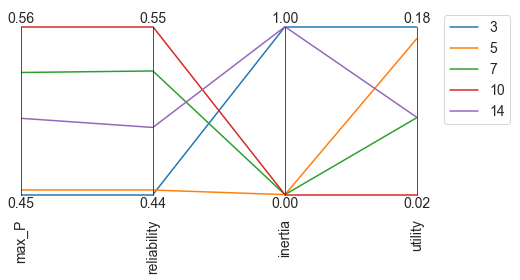

In [22]:
colors = sns.color_palette()

# we pass the column labels explicitly to ensure the same order
data = overall_robustness.loc[:, 
                              ['max_P', 'reliability', 'inertia', 'utility']]
limits = parcoords.get_limits(data)
# limits.loc[0, ['utility', 'inertia', 'reliability', 'max_P']] = 0

paraxes = parcoords.ParallelAxes(limits)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()

## 05. Vulnerability analysis using scenario discovery

We can continue our analysis further by identifying the vulnerability of a preferred policy, using the scenario discovery technique. By identifying vulnerability, we can prepare additional measures to safeguard the success of the policy.

In [23]:
#first we select the policy which vulnerability we want to observe
selected_outcomes = outcomes_df.loc[outcomes_df['policy']=='10']
selected_experiments = experiments.loc[experiments['policy']=='10']

#also prepare a cleaned experiments dataframe
cleaned_experiments = selected_experiments[selected_experiments.columns[:5]]
cleaned_experiments.reset_index(inplace=True, drop=True)

In [24]:
#we proceed with selecting a threshold below which a policy is deemed to fail
data = selected_outcomes[['reliability']]
data.reset_index(inplace=True)
ooi = data['reliability'] < np.percentile(data, 15)

Now we run the PRIM algorithm

In [25]:
from ema_workbench.analysis import prim

prim_alg = prim.Prim(cleaned_experiments, ooi, threshold=0.8)
box1 = prim_alg.find_box()

[MainProcess/INFO] 1000 points remaining, containing 300 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.121, coverage: 0.4033333333333333, density: 1.0 restricted_dimensions: 3


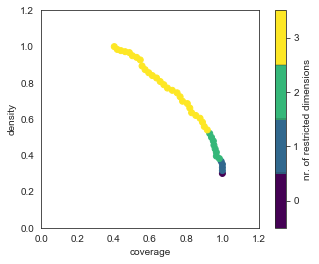

In [26]:
box1.show_tradeoff()
plt.show()

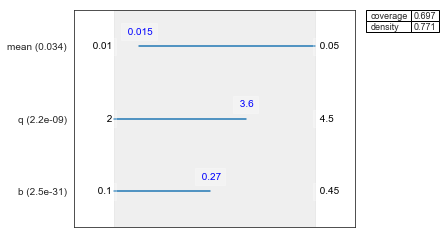

In [27]:
box1.inspect(25, style='graph')
plt.show()

## 06a. Extra1 - Exploring alternative epsilon values

Let's rerun the optimization, but with different epsilon values. Use \[0.5, 0.5, 0.5, 0.5\]

In [28]:
with MultiprocessingEvaluator(lake_model) as evaluator:
    results = evaluator.optimize(nfe=5000, epsilons=[0.5, 0.5, 0.5, 0.5])

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/5000 nfe
[MainProcess/INFO] generation 5: 500/5000 nfe
[MainProcess/INFO] generation 10: 1000/5000 nfe
[MainProcess/INFO] generation 15: 1500/5000 nfe
[MainProcess/INFO] generation 20: 2000/5000 nfe
[MainProcess/INFO] generation 25: 2500/5000 nfe
[MainProcess/INFO] generation 30: 3000/5000 nfe
[MainProcess/INFO] generation 35: 3500/5000 nfe
[MainProcess/INFO] generation 40: 4000/5000 nfe
[MainProcess/INFO] generation 45: 4500/5000 nfe
[MainProcess/INFO] optimization completed, found 4 solutions
[MainProcess/INFO] terminating pool


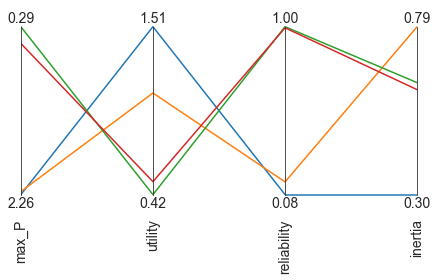

In [29]:
outcomes = results.loc[:, ['max_P', 'utility', 'reliability', 'inertia']]

limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)

# we invert this axis so direction of desirability is the same 
axes.invert_axis('max_P') 
plt.show()

We see that by making our epsilons higher, we are coursening the grid, and thus are reducing the number of solutions we find. Let's test this by making our epsilons smaller. We now expect to find more solutions. Let's use \[0.125, 0.05, 0.05\]

In [30]:
with MultiprocessingEvaluator(lake_model) as evaluator:
    results = evaluator.optimize(nfe=5000, epsilons=[0.125, 0.05, 0.05, 0.05])

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/5000 nfe
[MainProcess/INFO] generation 5: 500/5000 nfe
[MainProcess/INFO] generation 10: 1000/5000 nfe
[MainProcess/INFO] generation 15: 1500/5000 nfe
[MainProcess/INFO] generation 20: 2000/5000 nfe
[MainProcess/INFO] generation 25: 2500/5000 nfe
[MainProcess/INFO] generation 30: 3000/5000 nfe
[MainProcess/INFO] generation 35: 3500/5000 nfe
[MainProcess/INFO] generation 40: 4000/5000 nfe
[MainProcess/INFO] generation 45: 4500/5000 nfe
[MainProcess/INFO] optimization completed, found 46 solutions
[MainProcess/INFO] terminating pool


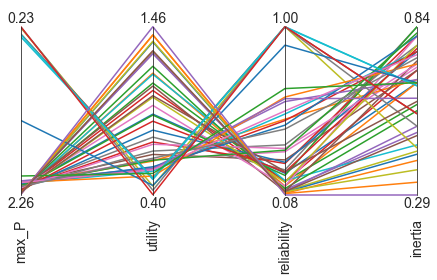

In [31]:
outcomes = results.loc[:, ['max_P', 'utility', 'reliability', 'inertia']]

limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)

# we invert this axis so direction of desirability is the same 
axes.invert_axis('max_P') 
plt.show()

And as expected, we now have many more solutions. Selecting appropriate epsilon values is tricky. It depends on case specific concerns (with what granularity do we want to find solutions?), as well as runtime considerations. The lower the epsilon values, the more solutions will be maintained in the Pareto set. Given how MOEA's work, this slows down the optimization. 

## 06b. Extra2 - Assessing convergence
Next to selecting appropriate epsilon values, a second key issue is assessing convergence. In the foregoing, we have been running the MOEA for 5000 function evaluations. Is this sufficient? Has the algorithm converged? We have no idea. So, how can we add convergence assessment? 

There exist a variety of metrics for assessing convergence of MOEAs. The workbench supports epsilong progress and hypervolume. Epsilon progress measures how often a solution in a new gridcel of the epsilon gridded output space is found. Early on, solutions in new grid cells are found quite frequently. Once the algorithm starts to converge, progress becomes more difficult and thus epsilon progress starts to stabilize. Hypervolume is a measure for how much of the objective space is covered by a given set of non-dominated solutions. THe higher the hypervolume, the larger the space is that is covered by the space. Again, hypervolume will grow quickly early on and starts to stabilize once the algorithm is converging. For a more elaborate description, have a look at [this blog](https://waterprogramming.wordpress.com/tag/hypervolume/). 

Since hypervolume requires specifying the objective space within which we want to calculate the volume, we need to know this space. Sometimes it is known a priori. For example in the lake problem, reliability is scalled between 0 and 1. In contrast, the bounds on max_P are not known up front. To help with this, we can introduce a constraint saying that max_P must be below a particulare threshold.


In [32]:
from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)
from ema_workbench import Constraint

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE,
                                     expected_range=(0,5)),
                       ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,2)),
                       ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE,
                                    expected_range=(0,1)),
                       ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,1))]

convergence_metrics = [HyperVolume.from_outcomes(lake_model.outcomes),
                       EpsilonProgress()]

constraints = [Constraint("max pollution", outcome_names="max_P",
                          function=lambda x:max(0, x-5))]

In [33]:
with MultiprocessingEvaluator(lake_model) as evaluator:
    results, convergence = evaluator.optimize(nfe=5000, searchover='levers',
                                    epsilons=[0.125, 0.05, 0.01, 0.01],
                                    convergence=convergence_metrics,
                                    constraints=constraints)


[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/5000 nfe
[MainProcess/INFO] generation 5: 500/5000 nfe
[MainProcess/INFO] generation 10: 1000/5000 nfe
[MainProcess/INFO] generation 15: 1500/5000 nfe
[MainProcess/INFO] generation 20: 2000/5000 nfe
[MainProcess/INFO] generation 25: 2500/5000 nfe
[MainProcess/INFO] generation 30: 3000/5000 nfe
[MainProcess/INFO] generation 35: 3500/5000 nfe
[MainProcess/INFO] generation 40: 4000/5000 nfe
[MainProcess/INFO] generation 45: 4500/5000 nfe
[MainProcess/INFO] optimization completed, found 103 solutions
[MainProcess/INFO] terminating pool


In [34]:
convergence

,hypervolume,epsilon_progress,nfe
0,0.000000,0,0
1,0.062973,36,100
2,0.101854,165,1100
3,0.172602,252,2100
4,0.193037,323,3100
5,0.196231,372,4100


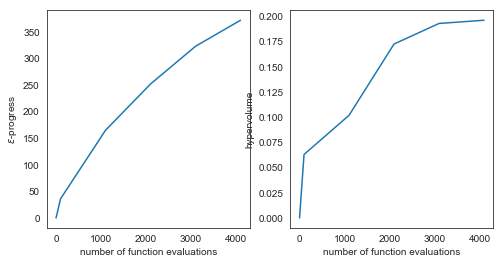

In [35]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

If we look at the above plots, we can see that neither hypervolume, nor $\epsilon$-progress has stablized. 5000 function evaluations is clearly not sufficient. Let's go to another extreme: 100.000. What happens in this case?

In [37]:
with MultiprocessingEvaluator(lake_model) as evaluator:
    results, convergence = evaluator.optimize(nfe=100000, searchover='levers',
                                    epsilons=[0.125, 0.05, 0.01, 0.01],
                                    convergence=convergence_metrics,
                                    constraints=constraints)



[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/100000 nfe
[MainProcess/INFO] generation 5: 500/100000 nfe
[MainProcess/INFO] generation 10: 1000/100000 nfe
[MainProcess/INFO] generation 15: 1500/100000 nfe
[MainProcess/INFO] generation 20: 2000/100000 nfe
[MainProcess/INFO] generation 25: 2500/100000 nfe
[MainProcess/INFO] generation 30: 3000/100000 nfe
[MainProcess/INFO] generation 35: 3500/100000 nfe
[MainProcess/INFO] generation 40: 4000/100000 nfe
[MainProcess/INFO] generation 45: 4500/100000 nfe
[MainProcess/INFO] generation 50: 5000/100000 nfe
[MainProcess/INFO] generation 55: 5500/100000 nfe
[MainProcess/INFO] generation 60: 6000/100000 nfe
[MainProcess/INFO] generation 65: 6500/100000 nfe
[MainProcess/INFO] generation 70: 7000/100000 nfe
[MainProcess/INFO] generation 75: 7500/100000 nfe
[MainProcess/INFO] generation 80: 8000/100000 nfe
[MainProcess/INFO] generation 85: 8500/100000 nfe
[MainProcess/INFO] generation 90: 9000/100000 nfe
[MainProcess/INFO] gener

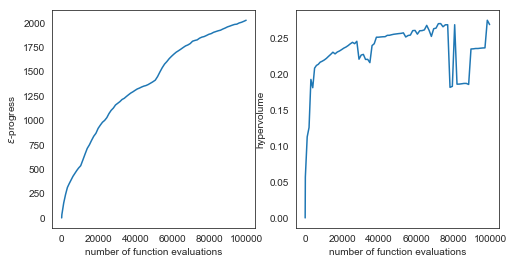

In [38]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

The runtime of this analysis has been substantial. Still, looking at the convergen graphs, hypervolume has more or less stablized, while $\epsilon$-progress only starts to stablize. This could be an argument for running the algorithm even longer (say 250.000 nfe). Establising the number of NFE is generally a form of trial and error. 

# Using an alternative optimization algorithm

In this example, I recommend to use Platypus with the ε-NSGAII algorithm, since it is shown to outperform many MOEA’s. For other algortihms, see the documentation of Platypus. For a comparison of them, you can have a look at [Reed et al (2013)](http://dx.doi.org/10.1016/j.advwatres.2012.01.005).

In [39]:
from ema_workbench.em_framework.optimization import GenerationalBorg

with MultiprocessingEvaluator(lake_model) as evaluator:
    results, convergence = evaluator.optimize(nfe=20000, searchover='levers',
                                    epsilons=[0.125, 0.05, 0.01, 0.01],
                                    convergence=convergence_metrics,
                                    constraints=constraints,
                                    algorithm=GenerationalBorg,
                                    logging_freq=50)


[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/20000 nfe
[MainProcess/INFO] generation 50: 5017/20000 nfe
[MainProcess/INFO] generation 100: 10038/20000 nfe
[MainProcess/INFO] optimization completed, found 109 solutions
[MainProcess/INFO] terminating pool


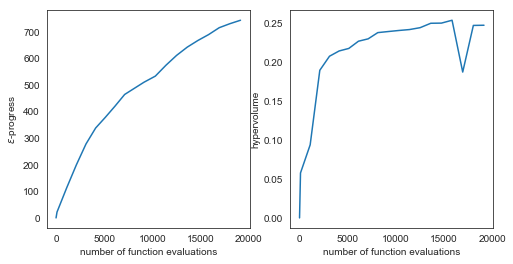

In [40]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()